# Generate Donut Catalogs and Refit WCS from Direct Detection

Owner: **Bryce Kalmbach** ([@jbkalmbach](https://github.com/lsst-ts/ts_analysis_notebooks/issues/new?body=@jbkalmbach))

Last Verified to Run: 2023-05-15

Software Versions:
* `ts_wep`: v6.3.2
* `lsst_distrib`: w_2023_17

In [1]:
from copy import copy
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval
from scipy.spatial import cKDTree

# LSST imports
import lsst.geom
from lsst.daf.butler import Butler
from lsst.ts.wep.task import GenerateDonutDirectDetectTaskConfig, GenerateDonutDirectDetectTask
from lsst.ts.wep.task import RefCatalogInterface
from lsst.meas.algorithms import ReferenceObjectLoader, LoadReferenceObjectsConfig
from lsst.ts.wep.task import GenerateDonutFromRefitWcsTask, GenerateDonutFromRefitWcsTaskConfig
from lsst.ts.wep.task import GenerateDonutCatalogWcsTask, GenerateDonutCatalogWcsTaskConfig

%matplotlib inline

## Notebook Objectives

1) Show how to create donut catalogs running a direct detection algorithm on processed images with `GenerateDonutDirectDetectTask`. 
2) Use `GenerateDonutsFromRefitWcsTask` to take those direct detect catalogs and fit a new WCS for the images and apply it to generate a donut catalog from the reference catalogs stored in the butler repository.
4) Show an example pipeline configuration that will run these steps using the DM pipeline framework.

## Logistics

This notebook is intended to be run at the [Rubin US Data Facility (USDF)](https://usdf-rsp.slac.stanford.edu/). All the data is available at the USDF.

## Get AuxTel image data

In this notebook we will run on data obtained with the Rubin Auxiliary Telescope (AuxTel).

The AuxTel data can be found in `/repo/embargo`.

In [2]:
repo_dir = '/sdf/group/rubin/repo/embargo/'

In [3]:
butler = Butler(repo_dir)

For this notebook we will use data from 3/10/2023 observing run. More information on available data from that night can be found in [this notebook](../../notebooks/auxtel/observing_runs/20230310/analyzeWepOutput.ipynb) or on [RubinTV](https://roundtable.lsst.codes/rubintv/summit/auxtel/historical/2023-03-10).

In [4]:
output_collection = 'u/brycek/latiss_wep_test/run_all_full_catalog'
data_id_intra = {'instrument': 'LATISS', 'exposure': 2023031000223, 'visit': 2023031000223, 'detector': 0}
data_id_extra = {'instrument': 'LATISS', 'exposure': 2023031000224, 'visit': 2023031000224, 'detector': 0}

### Load the postISR images

We will start from the point after ISR has been performed on the raw images and retrieve the `postISRCCD` images from the butler.

In [5]:
postIsrExtra = butler.get('postISRCCD', dataId=data_id_extra, collections=output_collection)
postIsrIntra = butler.get('postISRCCD', dataId=data_id_intra, collections=output_collection)

## Run donut detection with `GenerateDonutDirectDetectTask`

WCS fitting requires an initial catalog of sources detected on the image as input.
Therefore, the first step to fit a WCS on an image is to run `GenerateDonutDirectDetectTask` on the image and detect enough sources to create an initial input catalog.
Since it is always best for WCS fitting to get as large a catalog of sources from the image as possible we will configure `GenerateDonutDirectDetectTask` with a lower SNR threshold than the default.

In [6]:
# Set configurations
config = GenerateDonutDirectDetectTaskConfig()
config.measurementTask.nSigmaDetection = 3. # The default used in the full run stored in the butler is 20.
config.initialCutoutPadding = 5

# Set auxTel parameters (see https://github.com/lsst-ts/ts_wep/blob/develop/policy/cwfs/instData/auxTel/instParamPipeConfig.yaml for default auxtel instrument configuration).
config.instObscuration = 0.3525
config.instFocalLength = 21.6
config.instApertureDiameter = 1.2
config.instDefocalOffset = 32.8
config.instPixelSize = 10.0e-6
config.opticalModel = 'onAxis'

# Set donut selection parameters
config.donutSelector.useCustomMagLimit = True
config.donutSelector.unblendedSeparation = 160
config.donutSelector.maxBlended = 1
config.donutSelector.minBlendedSeparation = 0

In [7]:
camera = butler.get('camera', {'instrument': 'LATISS'}, collections='LATISS/calib/unbounded')

In [8]:
directDetectTask = GenerateDonutDirectDetectTask(config=config)
directDetectCat = directDetectTask.run(postIsrExtra, camera).donutCatalog

View the direct detect catalog and plot them on the image

In [9]:
directDetectCat

,coord_ra,coord_dec,centroid_x,centroid_y,detector,source_flux,blend_centroid_x,blend_centroid_y
0,2.306816,-0.684762,1965.629268,2212.671589,RXX_S00,2.910382e+08,[],[]
1,2.305866,-0.685119,517.104871,3216.541623,RXX_S00,4.476999e+06,[],[]
2,2.306805,-0.684354,2723.494812,2658.953143,RXX_S00,3.421002e+06,[],[]
3,2.308097,-0.684777,2985.898723,332.256788,RXX_S00,2.796512e+06,[],[]
4,2.306827,-0.685289,985.487885,1638.967432,RXX_S00,1.580994e+06,[],[]
5,2.306087,-0.685330,300.793457,2671.694812,RXX_S00,5.900634e+05,[],[]
6,2.307582,-0.684793,2534.392288,1064.694814,RXX_S00,5.529665e+05,[],[]
7,2.306213,-0.685164,716.779050,2663.284624,RXX_S00,5.521189e+05,[],[]
8,2.306279,-0.684057,2849.489390,3739.166863,RXX_S00,3.357654e+05,[],[]
9,2.308004,-0.685021,2450.424993,210.087157,RXX_S00,2.998492e+05,[],[]


Text(0, 0.5, 'Y Pixels')

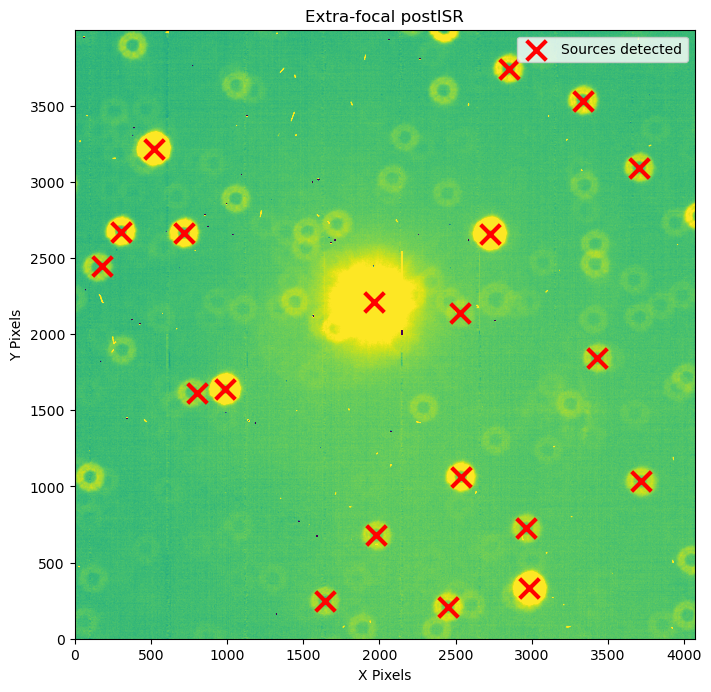

In [10]:
%matplotlib inline

fig=plt.figure(figsize=(8,8))

fig.add_subplot(1,1,1)
zscale_extra = ZScaleInterval().get_limits(postIsrExtra.image.array)
plt.imshow(postIsrExtra.image.array, norm=mpl.colors.AsinhNorm(vmin=zscale_extra[0], vmax=zscale_extra[1]), origin='lower')
plt.title('Extra-focal postISR')
plt.scatter(directDetectCat['centroid_x'], directDetectCat['centroid_y'], c='r', marker='x', lw=3, s=200, label="Sources detected")
plt.legend()
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')

This gives us a nice catalog of 20 sources we can use to fit a new WCS.

## Run WCS Fitting Task

### Use new `GenerateDonutFromRefitWcsTask`

This new task is designed to fit the WCS from the direct detect donut catalog and the astrometric reference catalog provided. 
Then if the fit is successful it will use the photometric reference catalog chosen to run the donut selection algorithm and create a new donut catalog.

In [11]:
fitConfig = GenerateDonutFromRefitWcsTaskConfig()

#### Task Configuration

The task and its configuration class are subclasses of `GenerateDonutCatalogWcsTask` and `GenerateDonutCatalogWcsTaskConfig`. For information on all the available configuration used for donut fitting available inherited here via those classes see the explainer notebook [wepSourceSelectionWithWcs.ipynb](wepSourceSelectionWithWcs.ipynb). 

The most relevant of the available configurations inherited is `anyFilterMapsToThis` which allows the user to define the filter name for the astrometry catalog. This is useful since Gaia filter names do not match the filter names of the incoming data.

There is a single additional configuration for this task along with an additional subtask, `astromTask`. The single configuration is:

* `maxFitScatter`: Maximum allowed scatter for a successful WCS fit (in arcseconds). 
The default value is set to 1.0. 
If the WCS fit does not meet this threshold then the fit will fail and the old WCS and direct detect catalog will be the task output.

The subtask initiated is `astromTask` and it is an instance of `AstrometryTask` that runs the astrometry matching and WCS fitting. Within `astromTask` there are also a set of subtasks with configurations that the user can specify to define the WCS fitting inputs and algorithm. These subtasks and most relevant configurations are:

* `matcher`: Handles matching of objects in the detected catalog to those in the reference catalog. The default subtask is `MatchPessimisticBTask` and a more complete list of configurations can be found [here](https://github.com/lsst/meas_astrom/blob/main/python/lsst/meas/astrom/matchPessimisticB.py#L81). A couple of the most commonly used configurations in this subtask are:
  * `maxRotationDeg`: Maximum rotation of possible WCS fits from input WCS
  * `maxOffsetPix`: Maximum offset in pixels between WCS fit and input WCS
* `referenceSelector`: Performs the selection of reference catalog sources for the matching. The default subtask is `ReferenceSourceSelectorTask` and more information can be found [here](https://pipelines.lsst.io/v/w_2023_01/modules/lsst.meas.algorithms/tasks/lsst.meas.algorithms.ReferenceSourceSelectorTask.html#lsst-task-lsst-meas-algorithms-sourceselector-referencesourceselectortaskhttps://pipelines.lsst.io/v/w_2023_01/modules/lsst.meas.algorithms/tasks/lsst.meas.algorithms.ReferenceSourceSelectorTask.html#lsst-task-lsst-meas-algorithms-sourceselector-referencesourceselectortask).

Here are some examples of how to set configurations on the subtasks for `astromTask`:

In [12]:
# Set anyFilterMapsToThis for the astrometry catalog
fitConfig.anyFilterMapsToThis = 'phot_g_mean'
# Change the maximum offset in pixels allowed when fitting WCS
fitConfig.astromTask.matcher.maxOffsetPix = 1000
# Change the maximum magnitude for reference catalog sources allowed in `phot_g_mean_flux` band.
fitConfig.astromTask.referenceSelector.magLimit.fluxField = "phot_g_mean_flux"
fitConfig.astromTask.referenceSelector.magLimit.maximum = 15.0

In [13]:
# Configure the donut selection subtask
fitConfig.doDonutSelection = True
fitConfig.donutSelector.useCustomMagLimit = True
fitConfig.donutSelector.magMax = 16.0
fitConfig.donutSelector.unblendedSeparation = 160
fitConfig.donutSelector.minBlendedSeparation = 1
fitConfig.donutSelector.maxBlended = 3

We provide the task with four inputs to run:

* **Astrometric reference catalogs**: Here we provide reference catalogs from Gaia.
* **Input PostISR exposure**
* **Donut Catalog**: Here we use a catalog generated above using `GenerateDonutDirectDetectTask`
* **Photometric reference catalogs**: This is used to generate donut catalogs based upon the donutSelector subtask.

We already have the postISR exposure and the donut catalog but we need to get an astrometric and a photometric reference catalog. 
We need accurate astrometry for the WCS fitting so we use Gaia because of its superior astrometric precision.
But we also need a photometric catalog to run source selection on our donuts and make accurate decisions concerning minimum and maximum magnitude cuts and deciding which donuts count as isolated in a given bandpass.
Since Gaia is not very deep and its bandpasses are not a good match for SDSS or LSST we use the PS1 catalog for photometry.

### Load reference catalogs

Only need to do this when running interactively. 
When run in a pipeline the pipetask framework takes care of all of this for you.
For available reference catalogs at the USDF see the README here: `/sdf/group/rubin/datasets/refcats/htm/README.txt`

#### Load astrometric reference catalog shards

For astrometry we use the Gaia DR2 catalog on USDF.

In [14]:
# Initialize with pointing information
info = postIsrExtra.getInfo()
visitInfo = info.getVisitInfo()
boresightRa, boresightDec = visitInfo.boresightRaDec
boresightRotAng = visitInfo.boresightRotAngle

refCatInterface = RefCatalogInterface(boresightRa.asDegrees(), 
                                      boresightDec.asDegrees(), 
                                      boresightRotAng.asDegrees())

In [15]:
htmIds = refCatInterface.getHtmIds()
# Use the shardIds found above to get the locations (`dataRefs`) in the butler repo for the catalog pieces we want
refCatButler = Butler('/sdf/data/rubin/repo/main/')
# Use Gaia for astrometry tasks
gaiaCatalogName = 'gaia_dr2_20200414'
collections = ['refcats/DM-28636']
gaiaDataRefs, gaiaDataIds = refCatInterface.getDataRefs(htmIds, refCatButler, gaiaCatalogName, collections)

In [16]:
gaiaRefCatConfig = LoadReferenceObjectsConfig(anyFilterMapsToThis='phot_g_mean')

In [17]:
gaiaRefCatLoader = ReferenceObjectLoader(gaiaDataIds, gaiaDataRefs, config=gaiaRefCatConfig)
gaiaRefCat = gaiaRefCatLoader.loadSkyCircle(visitInfo.boresightRaDec, lsst.geom.Angle(0.01), 'phot_g_mean')

#### Load photometric reference catalog shards

On USDF we use the Pan-Starrs reference catalogs available in the main butler repo.

In [18]:
htmIds = refCatInterface.getHtmIds()
# Use the shardIds found above to get the locations (`dataRefs`) in the butler repo for the catalog pieces we want
refCatButler = Butler('/sdf/data/rubin/repo/main/')
ps1CatalogName = 'ps1_pv3_3pi_20170110'
collections = ['refcats/DM-28636']
ps1DataRefs, ps1DataIds = refCatInterface.getDataRefs(htmIds, refCatButler, ps1CatalogName, collections)

In [19]:
ps1RefCatConfig = LoadReferenceObjectsConfig(anyFilterMapsToThis='r')

In [20]:
ps1RefCatLoader = ReferenceObjectLoader(ps1DataIds, ps1DataRefs, config=ps1RefCatConfig)
ps1RefCat = ps1RefCatLoader.loadSkyCircle(visitInfo.boresightRaDec, lsst.geom.Angle(0.01), 'r')

### Run Task

In [21]:
fitTask = GenerateDonutFromRefitWcsTask(config=fitConfig)

In [22]:
out = fitTask.run(gaiaDataRefs, copy(postIsrExtra), directDetectCat, ps1DataRefs)

The two outputs from the task are the `outputExposure` and the `donutCatalog`.

In [23]:
expNew = out.outputExposure
refCatOut = out.donutCatalog

#### Output Exposure

The new `outputExposure` is the same as the input except with an updated WCS.

In [24]:
expNew.wcs

FITS standard SkyWcs:
Sky Origin: (132.1869649644, -39.2330337477)
Pixel Origin: (2088, 2006)
Pixel Scale: 0.095632 arcsec/pixel

Compare to the original WCS

In [25]:
postIsrExtra.wcs

FITS standard SkyWcs:
Sky Origin: (132.1790459507, -39.2338178907)
Pixel Origin: (2088, 2006)
Pixel Scale: 0.095695 arcsec/pixel

The original WCS was close but there does seem to be a slight shift in both RA and Dec after fitting a new WCS.

#### Donut Catalog

In [26]:
refCatOut

,coord_ra,coord_dec,centroid_x,centroid_y,source_flux,blend_centroid_x,blend_centroid_y
0,2.306954,-0.684757,1951.800036,2205.711685,5.258068e+09,[],[]
1,2.306011,-0.685116,517.923237,3215.510887,9.899792e+07,[],[]
2,2.306938,-0.684342,2724.129490,2656.442889,7.211508e+07,[],[]
3,2.308235,-0.684751,2986.883861,332.103148,3.429462e+07,[],[]
4,2.306975,-0.685276,985.653086,1638.069107,2.790139e+07,[],[]
5,2.306359,-0.685158,715.880446,2661.883181,1.296659e+07,[],[]
6,2.306234,-0.685325,300.191426,2672.985097,1.139794e+07,[],[]
7,2.307721,-0.684773,2534.253901,1062.914427,1.108731e+07,[],[]
8,2.306405,-0.684051,2848.129850,3739.529983,8.302832e+06,[],[]
9,2.306654,-0.683899,3336.251709,3532.447132,6.468832e+06,[],[]


Text(0, 0.5, 'Y Pixels')

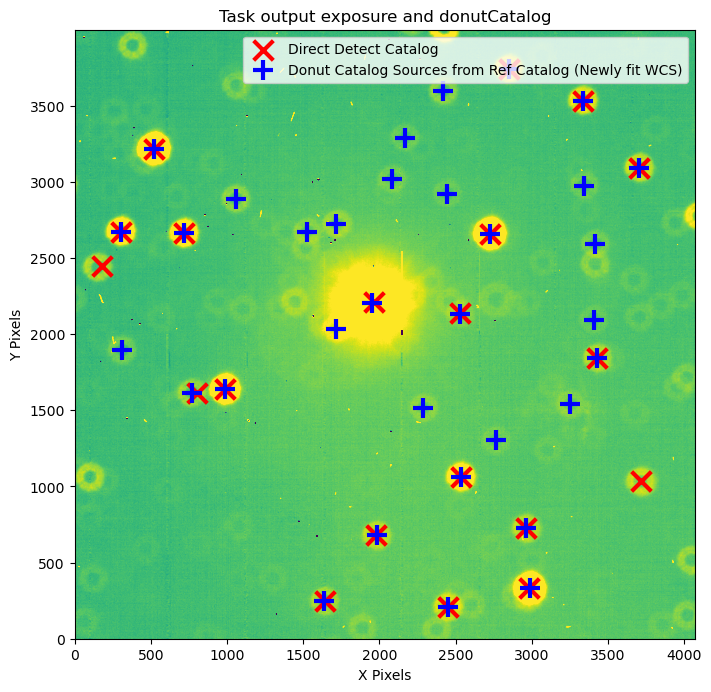

In [27]:
fig = plt.figure(figsize=(8,8))
zscale_extra = ZScaleInterval().get_limits(postIsrExtra.image.array)
plt.imshow(postIsrExtra.image.array, norm=mpl.colors.AsinhNorm(vmin=zscale_extra[0], vmax=zscale_extra[1]), origin='lower')
plt.title('Task output exposure and donutCatalog')
plt.scatter(directDetectCat['centroid_x'], directDetectCat['centroid_y'], c='r', marker='x', lw=3, s=200, label="Direct Detect Catalog")
plt.scatter(refCatOut['centroid_x'], refCatOut['centroid_y'], c='b', marker='+', lw=3, s=200, label="Donut Catalog Sources from Ref Catalog (Newly fit WCS)")
plt.legend()
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')

Let's examine how well our reference catalog objects match up to the direct detect catalog.

In [28]:
# Examine WCS fit offsets from detected catalog by running a crossmatch with a kdtree
kdtree = cKDTree(directDetectCat[['centroid_x', 'centroid_y']].values)
dist, ind = kdtree.query(refCatOut[['centroid_x', 'centroid_y']].values, k=1, distance_upper_bound=40.)

refCatIdx = np.where(dist != np.inf)[0]
directDetectIdx = ind[refCatIdx]

Text(0.5, 0, 'Total Pixel offset (refCat - directDetect)')

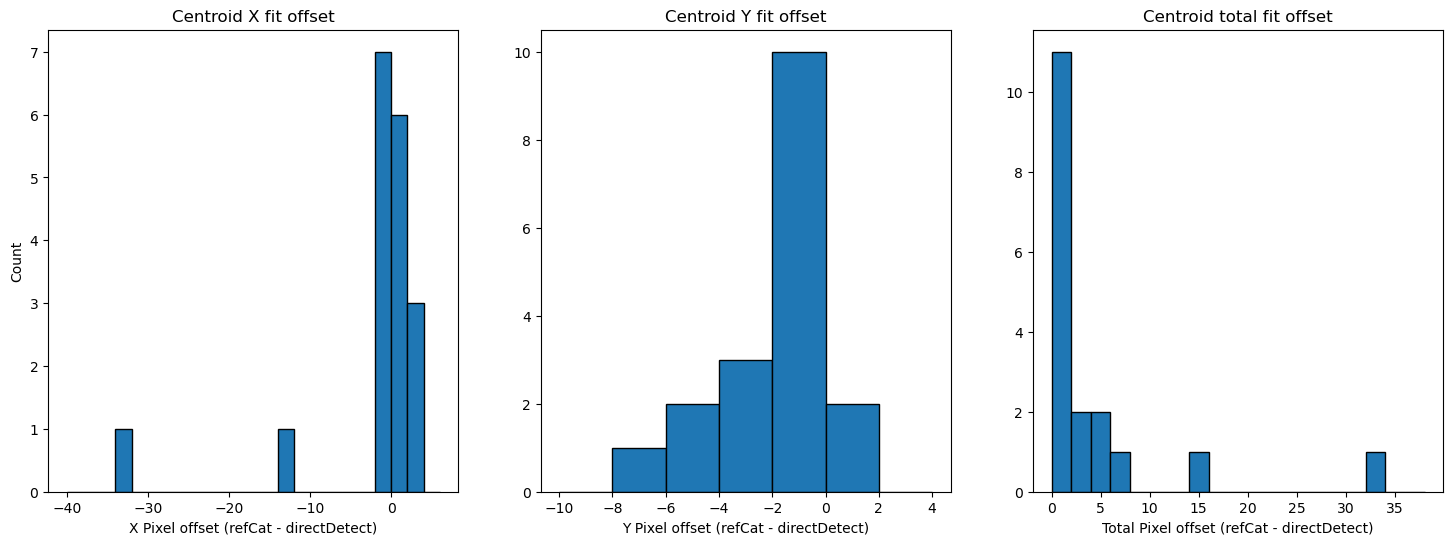

In [29]:
fig = plt.figure(figsize=(18, 6))
fig.add_subplot(1,3,1)
plt.hist(refCatOut['centroid_x'].values[refCatIdx] - directDetectCat['centroid_x'].values[directDetectIdx], bins=np.arange(-40, 7, 2), edgecolor="black")
plt.title('Centroid X fit offset')
plt.xlabel('X Pixel offset (refCat - directDetect)')
plt.ylabel('Count')

fig.add_subplot(1,3,2)
plt.hist(refCatOut['centroid_y'].values[refCatIdx] - directDetectCat['centroid_y'].values[directDetectIdx], bins=np.arange(-10, 5, 2), edgecolor="black")
plt.title('Centroid Y fit offset')
plt.xlabel('Y Pixel offset (refCat - directDetect)')

fig.add_subplot(1,3,3)
plt.hist(
    np.sqrt((refCatOut['centroid_y'].values[refCatIdx] - directDetectCat['centroid_y'].values[directDetectIdx])**2 + (refCatOut['centroid_x'].values[refCatIdx] - directDetectCat['centroid_x'].values[directDetectIdx])**2),
    bins=np.arange(0, 40, 2),
    edgecolor="black"
)
plt.title('Centroid total fit offset')
plt.xlabel('Total Pixel offset (refCat - directDetect)')

For 16 out of the 18 objects that appear in both catalogs the fit is within 7 pixels. 
The two objects with degraded fits are the center donut which is saturated and so the initial centroid from donut detection is unreliable and the very poor fit is an object that according to the reference catalog is blended with 3 other objects.

#### WCS comparison

To demonstrate the difference between the input WCS and newly fit WCS we will compare a donut catalog created with the reference catalogs and the original WCS to the output from `GenerateDonutFromRefitWcs`.

In [30]:
refCatGenConfig = GenerateDonutCatalogWcsTaskConfig()

In [31]:
refCatGenConfig.doDonutSelection = True
refCatGenConfig.donutSelector.useCustomMagLimit = True
refCatGenConfig.donutSelector.magMax = 16.0
refCatGenConfig.donutSelector.unblendedSeparation = 160
refCatGenConfig.donutSelector.minBlendedSeparation = 1
refCatGenConfig.donutSelector.maxBlended = 3

In [32]:
refCatGenTask = GenerateDonutCatalogWcsTask(config=refCatGenConfig)

In [33]:
refCatOutOriginalWcs = refCatGenTask.run(ps1DataRefs, postIsrExtra).donutCatalog

Text(0, 0.5, 'Y Pixels')

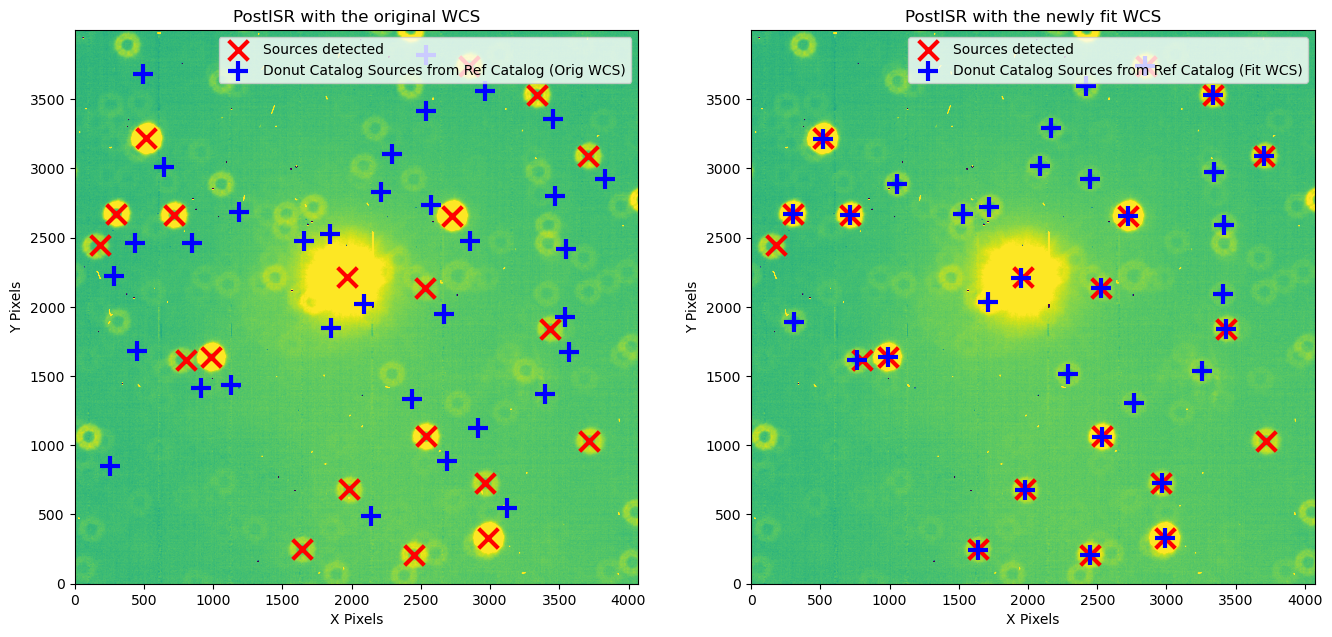

In [34]:
%matplotlib inline

fig=plt.figure(figsize=(16,8))

fig.add_subplot(1,2,1)
zscale_extra = ZScaleInterval().get_limits(postIsrExtra.image.array)
plt.imshow(postIsrExtra.image.array, norm=mpl.colors.AsinhNorm(vmin=zscale_extra[0], vmax=zscale_extra[1]), origin='lower')
plt.title('PostISR with the original WCS')
plt.scatter(directDetectCat['centroid_x'], directDetectCat['centroid_y'], c='r', marker='x', lw=3, s=200, label="Sources detected")
plt.scatter(refCatOutOriginalWcs['centroid_x'], refCatOutOriginalWcs['centroid_y'], c='b', marker='+', lw=3, s=200, label="Donut Catalog Sources from Ref Catalog (Orig WCS)")
plt.legend()
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')

fig.add_subplot(1,2,2)
zscale_extra = ZScaleInterval().get_limits(postIsrExtra.image.array)
plt.imshow(postIsrExtra.image.array, norm=mpl.colors.AsinhNorm(vmin=zscale_extra[0], vmax=zscale_extra[1]), origin='lower')
plt.title('PostISR with the newly fit WCS')
plt.scatter(directDetectCat['centroid_x'], directDetectCat['centroid_y'], c='r', marker='x', lw=3, s=200, label="Sources detected")
plt.scatter(refCatOut['centroid_x'], refCatOut['centroid_y'], c='b', marker='+', lw=3, s=200, label="Donut Catalog Sources from Ref Catalog (Fit WCS)")
plt.legend()
plt.xlabel('X Pixels')
plt.ylabel('Y Pixels')

Here we can see the results of the WCS fitting and the original WCS compared.
The new WCS is a clear improvement that corrects an initial offset of 150-200 of pixels in the WCS both toward the bottom of the exposure and to the right.
This shift is visible in the above figure on the left where the reference catalog objects placed on the sky with the initial WCS (the blue crosses) are systematically shifted away from the detected donuts (red X's).
Fitting for a new, more accurate WCS places the reference catalog sources on top of their detected locations (as seen in the right image) allows us to use the reference catalogs to create more comprehensive donut catalogs with our WEP pipeline. 
Without WCS fitting this wouldn't be possible as we would be cutting out postage stamps well away from the actual sources.

## Task failure modes and associated metadata flags

`GenerateDonutFromRefitWcsTask` has two flags available in the task metadata to record success or failure of the WCS task and the donut catalog generation:

* `wcsFitSuccess` records the sucess or failure of the WCS fitting. 
If this is set to `False` then the original WCS from the incoming image will be used and the output exposure will have the same WCS as the input. 
In addition, the output donut catalog will just be the direct detect catalogs.

* `refCatalogSuccess` records the success or failure of generating a donut catalog from the photometric reference catalogs provided.
If this is set to `False` then the input reference catalogs did not cover the exposure footprint.
Additionally, the exposure with the updated WCS (if `wcsFitSuccess` is `True`) will be returned as output but the original direct detect catalog will be returned as the donut catalog.

Along with these tags set in the task metadata there are also `WARNING` log messages printed to command line and stored in the task log.

### wcsFitSuccess

Here we run with no astrometric catalog to trigger WCS fit errors.

In [35]:
out = fitTask.run([], copy(postIsrExtra), directDetectCat, ps1DataRefs)

`wcsFitSuccess` will be set to `False` as a result of the WCS failure.

In [36]:
fitTask.metadata['wcsFitSuccess']

False

The donut catalog and exposure WCS will be the same.

In [37]:
print(f'Is output WCS the same as the input? {out.outputExposure.wcs == postIsrExtra.wcs}')
print(f'Is output donut catalog the same as the direct detect catalog? {np.array_equal(out.donutCatalog, directDetectCat)}')

Is output WCS the same as the input? True
Is output donut catalog the same as the direct detect catalog? True


### refCatalogSuccess

In this case, we run without the photometric reference catalog.

In [38]:
out = fitTask.run(gaiaDataRefs, copy(postIsrExtra), directDetectCat, [])

In this case, the WCS fit succeeds so `wcsFitSuccess` will be `True`.

In [39]:
fitTask.metadata['wcsFitSuccess']

True

But the donut catalog generation from the reference catalog will fail so `refCatalogSuccess` will be `False`.

In [40]:
fitTask.metadata['refCatalogSuccess']

False

The WCS will be different because that was successful but the donut catalog will the same as the direct detect catalog due to the reference catalog failure.

In [41]:
print(f'Is output WCS the same as the input? {out.outputExposure.wcs == postIsrExtra.wcs}')
print(f'Is output donut catalog the same as the direct detect catalog? {np.array_equal(out.donutCatalog, directDetectCat)}')

Is output WCS the same as the input? False
Is output donut catalog the same as the direct detect catalog? True


## Running `GenerateDonutFromRefitWcsTask` in the WEP pipeline

`GenerateDonutFromRefitWcsTask` can be run as part of the WEP pipeline as an additional step after the creation of a direct detect donut catalog with `GenerateDonutDirectDetectTask`.

The key changes to make in the pipeline file are shown below and are the specification of the `connections` between tasks:

1) We make sure to redefine the output of the `ISR` task to be a `preFitPostISRCCD` instead of the default `postISRCCD` and make sure that `generateDonutDirectDetectTask` looks for this as the input exposure to its task. `GenerateDonutFromRefitWcsTask` will by default look for an input called `preFitPostISRCCD` and the output of the task will be a `postISRCCD` that `generateDonutCatalogWcsTask` expects. 

2) The other `connection` configuration to change is the output catalog name from `generateDonutCatalogDirectDetectTask` which is renamed to be a `directDetectDonutCatalog`. 

3) Finally, if you wish to use reference catalogs other than the default Gaia and PS1 reference catalogs for astrometry and photometry, respectively, then you must give the names to the appropriate connections in the `GenerateDonutFromRefitWcsTask` section.

Both the `preFitPostISRCCD` and the `directDetectDonutCatalog` will be saved in the butler repository along with the `postISRCCD` and `donutCatalog` saved as the output of `GenerateDonutFromRefitWcsTask`.

```yaml
# This yaml file is used to define the tasks and configuration of
# a Gen 3 pipeline used for testing in ts_wep.
description: wep basic processing test pipeline
# Here we specify the corresponding instrument for the data we
# will be using.
instrument: lsst.obs.lsst.LsstCam
# Then we can specify each task in our pipeline by a name
# and then specify the class name corresponding to that task
tasks:
  isr:
    class: lsst.ip.isr.isrTask.IsrTask
    # Below we specify the configuration settings we want to use
    # when running the task in this pipeline. Since our data doesn't
    # include bias or flats we only want to use doApplyGains and
    # doOverscan in our isr task.
    config:
      # Change the name of the output exposure to reflect it is
      # before fitting
      connections.outputExposure: 'preFitPostISRCCD'
      doBias: False
      doVariance: False
      doLinearize: False
      doCrosstalk: False
      doDefect: False
      doNanMasking: False
      doInterpolate: False
      doBrighterFatter: False
      doDark: False
      doFlat: False
      doApplyGains: True
      doFringe: False
      doOverscan: True
      python: OverscanCorrectionTask.ConfigClass.fitType = 'MEDIAN'
  generateDonutDirectDetectTask:
    class: lsst.ts.wep.task.generateDonutDirectDetectTask.GenerateDonutDirectDetectTask
    config:
      # This incoming exposure needs to match the new name
      # of the output exposure from ISR
      connections.exposure: 'preFitPostISRCCD'
      # Give this donutCatalog a new name since we are creating
      # a donutCatalog in the GenerateDonutFromRefitWcsTask.
      connections.donutCatalog: 'directDetectDonutCatalog'
      instObscuration: 0.61
      instFocalLength: 10.312
      instApertureDiameter: 8.36
      instDefocalOffset: 1.5
      instPixelSize: 10.0e-6
  generateDonutFromRefitWcsTask:
    class: lsst.ts.wep.task.generateDonutFromRefitWcsTask.GenerateDonutFromRefitWcsTask
    config:
      # Specify the reference catalog names
      connections.astromRefCat: 'cal_ref_cat'
      connections.photoRefCat: 'cal_ref_cat'
      astromTask.referenceSelector.doMagLimit: False
      donutSelector.unblendedSeparation: 1
  cutOutDonutsScienceSensorTask:
    class: lsst.ts.wep.task.cutOutDonutsScienceSensorTask.CutOutDonutsScienceSensorTask
    config:
      # Test with default instrument configuration parameters
      donutTemplateSize: 160
      donutStampSize: 160
      initialCutoutPadding: 40
  calcZernikesTask:
    class: lsst.ts.wep.task.calcZernikesTask.CalcZernikesTask
```